In [ ]:
# 한글 폰트문제
# 이거 실행한다음 -> 런타임 다시시작 누르고 -> 다시 이거 실행하면 됨!!
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import glob
import re

from tqdm import tqdm_notebook

In [ ]:
# 크롤링한 전체 댓글 데이터 불러오기
raw_data = pd.read_csv('/content/gdrive/My Drive/eda_data/repl_data.csv')

# 전체 데이터 개수
len(raw_data)

127125

In [ ]:
# 중복 댓글 제거
repl_data = raw_data.drop_duplicates(subset='댓글', keep='first', inplace=False)

# 결측치 제거
repl_data = repl_data.loc[repl_data['댓글'].notnull(), ]

# 중복&결측치 제거 데이터 개수
len(repl_data)

118999

In [ ]:
# 정규표현식 전과 후를 비교하기 위해 세로운 데이터프레임 생성
preprocessing_df = repl_data.copy()
preprocessing_df.head()


Unnamed: 0  ...                               출처
0           0  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
1           1  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
2           2  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
3           3  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
4           4  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv

[5 rows x 4 columns]

In [ ]:
# @[아이디] 제거
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.replace('@[a-zA-Z가-힣\w\.\_\d]+', '')


In [ ]:
# 한글/영어/숫자를 제외한 문자제거 : 이모티콘이나 특수문자를 제거한다
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.replace('[^a-zA-Z가-힣0-9ㄱ-ㅎㅏ-ㅣ\s]', '')
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.replace('\s[\s*]', '')

In [ ]:
# 양 옆 빈 공백 제거
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.rstrip()
preprocessing_df['댓글'] = preprocessing_df['댓글'].str.lstrip()

In [ ]:
# 빈댓글 제거
preprocessing_df = preprocessing_df[preprocessing_df['댓글'] != '']
preprocessing_df = preprocessing_df[preprocessing_df['댓글'] != ' ']

In [ ]:
source_df = preprocessing_df
source_df.head()

Unnamed: 0  ...                               출처
1           1  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
2           2  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
3           3  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
4           4  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
5           5  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv

[5 rows x 4 columns]

In [ ]:
# 영어만 있는 행 제거
preprocessing_df = preprocessing_df['댓글']

In [ ]:
comment_df = pd.DataFrame(preprocessing_df)
display(comment_df.head())
print(comment_df['댓글'].str.lower())

댓글
1  심각허다 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받네 ...
2  차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도 차도 ...
3                                국회의원직 다 박탈했으면 좋겠네ㅠㅠ
4                                 표 얻을 생각 말고 법을 만들어라
5                       초딩 애들이 몰고다니는 형형색색 씽씽이 생각했나보네

1         심각허다 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받네 ...
2         차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도 차도 ...
3                                       국회의원직 다 박탈했으면 좋겠네ㅠㅠ
4                                        표 얻을 생각 말고 법을 만들어라
5                              초딩 애들이 몰고다니는 형형색색 씽씽이 생각했나보네
                                ...                        
127118                                              오빠 어디예요
127119                                               외국 갔어요
127121                                 이건 홍마담에서 구입 못하나요 ㅎㅎㅎ
127122                                           느무 잘먹는 예 9
127123                               맛있는건 눈으로만 봐도 알죠맛있게 드세요
Name: 댓글, Length: 109635, dtype: object


In [ ]:
preprocessing_df = comment_df[~comment_df['댓글'].str.isalpha()]

In [ ]:
preprocessing_df.shape

(92063, 1)

**악성단어 뭉치 필터링 - 라벨2**

In [ ]:
preprocessing_df['악플여부'] = np.NaN
preprocessing_df.head()

댓글  악플여부
1  심각허다 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받네 ...   NaN
2  차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도 차도 ...   NaN
3                                국회의원직 다 박탈했으면 좋겠네ㅠㅠ   NaN
4                                 표 얻을 생각 말고 법을 만들어라   NaN
5                       초딩 애들이 몰고다니는 형형색색 씽씽이 생각했나보네   NaN

In [ ]:
filter_word_df = pd.read_excel('/content/gdrive/My Drive/eda_data/필터링단어.xlsx')

In [ ]:
filter_word_df.shape[1]

13

In [ ]:
for col in tqdm_notebook(range(filter_word_df.shape[1])):
    word_list = list(filter_word_df.iloc[:, col])[0].split(', ')
    label = filter_word_df.columns[col][-2]

    for filter_word in tqdm_notebook(word_list):
        preprocessing_df.loc[ preprocessing_df['댓글'].str.match('.*' + filter_word + '.*'), '악플여부' ] = label

In [ ]:
print(preprocessing_df.head())
preprocessing_df.info()

                                                  댓글 악플여부
1  심각허다 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받네 ...  NaN
2  차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도 차도 ...  NaN
3                                국회의원직 다 박탈했으면 좋겠네ㅠㅠ  NaN
4                                 표 얻을 생각 말고 법을 만들어라  NaN
5                       초딩 애들이 몰고다니는 형형색색 씽씽이 생각했나보네  NaN
<class 'pandas.core.frame.DataFrame'>
Int64Index: 92063 entries, 1 to 127123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   댓글      92063 non-null  object
 1   악플여부    8856 non-null   object
dtypes: object(2)
memory usage: 2.1+ MB


In [ ]:
# 악플 필터링된 개수 확인
preprocessing_df.fillna(0,  inplace=True)
word_label = preprocessing_df.groupby(['악플여부']).size()
word_label_df = pd.DataFrame(word_label)
word_label_df.columns = ['개수']
word_label_df

개수
악플여부       
0     83207
2      8856

## 악플 필터링/노필터링 워드클라우드

In [ ]:
!pip install nltk
!pip install --upgrade pip
!pip install JPype1-1.1.2-cp38-cp38-win_amd64.whl
!pip install konlpy
!pip install wordcloud
!pip install --upgrade gensim

     |████████████████████████████████| 1.5MB 12.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
ERROR: JPype1-1.1.2-cp38-cp38-win_amd64.whl is not a supported wheel on this platform.
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 453 kB 62.8 MB/s 
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 24.2 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from konlpy.corpus import kobill
from konlpy.corpus import kolaw

In [ ]:
# 악플여부 0,2 로 나눔
normal_comment = preprocessing_df[preprocessing_df['악플여부']==0]
bad_comment = preprocessing_df[preprocessing_df['악플여부']!=0]
display(normal_comment)
bad_comment


댓글 악플여부  댓글길이
1       심각허다 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받네 ...    0    60
2       차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도 차도 ...    0   132
3                                     국회의원직 다 박탈했으면 좋겠네ㅠㅠ    0    19
4                                      표 얻을 생각 말고 법을 만들어라    0    18
5                            초딩 애들이 몰고다니는 형형색색 씽씽이 생각했나보네    0    28
...                                                   ...  ...   ...
127118                                            오빠 어디예요    0     7
127119                                             외국 갔어요    0     6
127121                               이건 홍마담에서 구입 못하나요 ㅎㅎㅎ    0    20
127122                                         느무 잘먹는 예 9    0    10
127123                             맛있는건 눈으로만 봐도 알죠맛있게 드세요    0    22

[83207 rows x 3 columns]

댓글 악플여부  댓글길이
103                                        지랄을 한다 역격리 고맙다    2    14
119                                      지네때문에 온나라가 지랄낫는데    2    16
130                                              짱꺄나 쪽바리나    2     8
174                  지랄한다미세먼지나 잡아라 중국에 말도 못하면서 말은 잘도 씨부린다    2    36
256                                아무리 내새끼라도 다리병신 만들어버렸을듯    2    22
...                                                   ...  ...   ...
125162                        진짜 ㅋㅋㅋ 댓글 지우는거 보소참 성격 병신 맞가    2    27
125451  진짜 대박이다언니힘내세요그냥이럴때 공인이고 모고 다 뒤로하시고 사이다 날려요저런애들...    2    71
126627  올바른길이란게 정해지지않는듯오빠가 열심히하시고 즐겁게 시간보내는것이 오빠만의 길인듯...    2    84
127000  석천오빠님사랑해요 레스토랑 한번 가본 촌년이지만행복한 기억이였고늘 오빠가 잘 되길 ...    2    57
127100                                        오빠가 더 행복하세요    2    11

[8856 rows x 3 columns]

In [ ]:
# 각각 txt파일로 저장
normal = normal_comment['댓글']
normal.to_csv('/content/gdrive/My Drive/eda_data/normal_comment.txt', sep = '\t', index=False, header=False)
bad = bad_comment['댓글']
bad.to_csv('/content/gdrive/My Drive/eda_data/bad_comment.txt', sep = '\t', index=False, header=False)



In [ ]:
# 악플여부 0
# normal_comment
doc_ko_new = open('/content/gdrive/My Drive/eda_data/normal_comment.txt').read()
doc_ko_new

'심각허다 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받네 주민소환제는 또 반대했겠지\n차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도 차도 다 안되면 왜 만든것이며 자전거도로 인프라도 개판인데 면허 자격은 왜 없엔것이며 애들 장난감으로 보나 이론으로만 에코 친환경에너지 씨부리지말고 현실을 봐라\n국회의원직 다 박탈했으면 좋겠네ㅠㅠ\n표 얻을 생각 말고 법을 만들어라\n초딩 애들이 몰고다니는 형형색색 씽씽이 생각했나보네\n저런것들을 국회에 앉혀놓았다니쯧쯧\nzzzzzzz ㅋㅋㅋㅋㅋㅋㅋ진짜 6갑들떤다\n전동킥보드타다죽어나가봐야 위험한줄알지\n정치하는게 제일 쉬운거 같다\nㅡㅡ 급하게 만드는 법은 저런가봅니다\n킥로드 업자들의 입법로비가 상당히 의심되는 규제완화\n애초에 규제완화 법안을 발의한 국회의원이 누구인가요\n이건좀안타봐서 모른다고하면서 완화하여태 이렇게 일한거에요\n국짐당이 민생법안 만들리가 없지\nㅅㅂ 욕나오게 하네 법안 폐기하고 다시 만들어라\nKorean companies burn Papua forests for palm oil\n화재는 원인 조사를 통한 예방이 최선입니다 그래도 소방청 통계로 매일 발생하는 화재 117건 속에 오늘도 누군가는 돌아가십니다 화재 발생시 화재가 발생한 세대방화구획에 난로처럼 화염 연기와 유독가스를 가두는겁니다 현관 문틈으로 배관틈새로 배관속으로 건물 틈새를 통해 순식간에 계단을 화염 연기와 유독가스로 꽉채우고 이웃집도 그 틈새로 연통으로 순식간에 사방으로 확산되는걸 못막는게 아니라 안막는겁니다 ㅠ 우리집 화재로 인한 아파트 전체 화재 피해는 우리집 책임입니다 다른 집 새벽 화재는 우리 가족이 질식사합니다 틈새밀폐재인 방화재Firestop기준이 엉터리 짝퉁 국토교통부 내화충전구조용 방화제 기준 덕분에 오히려 인명살상용 시안화수소유독가스와 화염 연기와 유독가스를 마구 내뿜고 있습니다 눈으로 보고도 ㅠ 설마 ㅎㅎ 살인자를 방에 가두고 도망가실래요 문열어 놓고 술래잡기 하실

In [ ]:
from konlpy.tag import Okt
t = Okt()
tokens_ko = t.nouns(doc_ko_new)
tokens_ko

['심각',
 '법안',
 '검토',
 '안',
 '의원',
 '내',
 '세금',
 '호의호식',
 '생각',
 '열',
 '주민',
 '환제',
 '또',
 '반대',
 '차도',
 '제한',
 '어쩌',
 '자전거',
 '오토바이',
 '그거',
 '인도',
 '차도',
 '왜',
 '자전거',
 '도로',
 '인프라',
 '개판',
 '면허',
 '자격',
 '왜',
 '것',
 '애',
 '장난감',
 '보나',
 '이론',
 '에코',
 '친환경',
 '에너지',
 '현실',
 '국회',
 '의원직',
 '박탈',
 '표',
 '생각',
 '법',
 '초딩',
 '애',
 '형형색색',
 '생각',
 '것',
 '국회',
 '쯧쯧',
 '진짜',
 '갑',
 '킥',
 '보드',
 '알',
 '정치',
 '제일',
 '법',
 '저런',
 '킥',
 '로드',
 '업자',
 '입법',
 '로비',
 '의심',
 '규제',
 '완화',
 '애초',
 '규제',
 '완화',
 '법안',
 '발의',
 '국회의원',
 '누구',
 '이건',
 '좀',
 '안타',
 '완화',
 '여태',
 '거',
 '국짐',
 '민생',
 '법안',
 '리가',
 '욕',
 '법안',
 '폐기',
 '다시',
 '화재',
 '원인',
 '조사',
 '통한',
 '예방',
 '최선',
 '소방청',
 '통계',
 '매일',
 '발생',
 '화재',
 '건',
 '속',
 '오늘',
 '누군가',
 '화재',
 '발생',
 '시',
 '화재',
 '발생',
 '방화',
 '구획',
 '난로',
 '화염',
 '연기',
 '유독가스',
 '현관',
 '문틈',
 '배관',
 '틈새',
 '배',
 '관속',
 '건물',
 '틈새',
 '통해',
 '순식간',
 '계단',
 '화염',
 '연기',
 '유독가스',
 '꽉',
 '이웃집',
 '그',
 '틈새',
 '연통',
 '순식간',
 '사방',
 '확산',
 '우리',
 '집',
 '화재',
 '아파트',
 '전체',
 

In [ ]:
# 두글자 이상만 뽑음
new_list = []
for word in tokens_ko:
    if len(word) >= 2:
        new_list.append(word)

In [ ]:
new_list

['심각',
 '법안',
 '검토',
 '의원',
 '세금',
 '호의호식',
 '생각',
 '주민',
 '환제',
 '반대',
 '차도',
 '제한',
 '어쩌',
 '자전거',
 '오토바이',
 '그거',
 '인도',
 '차도',
 '자전거',
 '도로',
 '인프라',
 '개판',
 '면허',
 '자격',
 '장난감',
 '보나',
 '이론',
 '에코',
 '친환경',
 '에너지',
 '현실',
 '국회',
 '의원직',
 '박탈',
 '생각',
 '초딩',
 '형형색색',
 '생각',
 '국회',
 '쯧쯧',
 '진짜',
 '보드',
 '정치',
 '제일',
 '저런',
 '로드',
 '업자',
 '입법',
 '로비',
 '의심',
 '규제',
 '완화',
 '애초',
 '규제',
 '완화',
 '법안',
 '발의',
 '국회의원',
 '누구',
 '이건',
 '안타',
 '완화',
 '여태',
 '국짐',
 '민생',
 '법안',
 '리가',
 '법안',
 '폐기',
 '다시',
 '화재',
 '원인',
 '조사',
 '통한',
 '예방',
 '최선',
 '소방청',
 '통계',
 '매일',
 '발생',
 '화재',
 '오늘',
 '누군가',
 '화재',
 '발생',
 '화재',
 '발생',
 '방화',
 '구획',
 '난로',
 '화염',
 '연기',
 '유독가스',
 '현관',
 '문틈',
 '배관',
 '틈새',
 '관속',
 '건물',
 '틈새',
 '통해',
 '순식간',
 '계단',
 '화염',
 '연기',
 '유독가스',
 '이웃집',
 '틈새',
 '연통',
 '순식간',
 '사방',
 '확산',
 '우리',
 '화재',
 '아파트',
 '전체',
 '화재',
 '피해',
 '우리',
 '책임',
 '다른',
 '새벽',
 '화재',
 '우리',
 '가족',
 '질식사',
 '틈새',
 '밀폐',
 '재인',
 '화재',
 '기준',
 '엉터리',
 '짝퉁',
 '국토교통부',
 '내화',
 '충전',
 '구조',
 '화제',
 '기준

In [ ]:
from collections import Counter
count = Counter(new_list)
count

Counter({'심각': 21,
         '법안': 49,
         '검토': 18,
         '의원': 111,
         '세금': 427,
         '호의호식': 9,
         '생각': 2384,
         '주민': 79,
         '환제': 1,
         '반대': 207,
         '차도': 18,
         '제한': 46,
         '어쩌': 75,
         '자전거': 130,
         '오토바이': 19,
         '그거': 338,
         '인도': 52,
         '도로': 51,
         '인프라': 18,
         '개판': 69,
         '면허': 26,
         '자격': 65,
         '장난감': 8,
         '보나': 17,
         '이론': 23,
         '에코': 2,
         '친환경': 15,
         '에너지': 39,
         '현실': 313,
         '국회': 113,
         '의원직': 3,
         '박탈': 24,
         '초딩': 89,
         '형형색색': 1,
         '쯧쯧': 8,
         '진짜': 3496,
         '보드': 74,
         '정치': 529,
         '제일': 352,
         '저런': 596,
         '로드': 28,
         '업자': 69,
         '입법': 10,
         '로비': 9,
         '의심': 100,
         '규제': 59,
         '완화': 6,
         '애초': 224,
         '발의': 15,
         '국회의원': 142,
         '누구': 475,
        

In [ ]:
# 빈도수 높은 것만 추출
words = dict(count.most_common())
words

{'대통령': 4517,
 '사람': 3822,
 '진짜': 3496,
 '새끼': 2953,
 '생각': 2384,
 '우리': 2207,
 '응원': 2059,
 '존나': 1943,
 '한국': 1733,
 '국민': 1658,
 '그냥': 1624,
 '중국': 1597,
 '지금': 1525,
 '항상': 1524,
 '미국': 1446,
 '나라': 1426,
 '문재인': 1243,
 '사랑': 1215,
 '보고': 1079,
 '하나': 1054,
 '정도': 1052,
 '여기': 969,
 '때문': 960,
 '여자': 956,
 '정말': 949,
 '일베': 948,
 '대한민국': 929,
 '일본': 918,
 '소리': 907,
 '지지': 905,
 '시발': 888,
 '문제': 857,
 '게이': 834,
 '댓글': 794,
 '씨발': 793,
 '전라도': 785,
 '트럼프': 779,
 '이제': 769,
 '코로나': 761,
 '이기': 733,
 '계란': 714,
 '재앙': 703,
 '건강': 699,
 '자기': 691,
 '마음': 687,
 '존경': 687,
 '다시': 679,
 '국가': 670,
 '익명': 662,
 '부정선거': 657,
 '무슨': 647,
 '홍어': 643,
 '제발': 638,
 '사진': 629,
 '남자': 609,
 '누가': 607,
 '어디': 601,
 '화이팅': 601,
 '정부': 597,
 '저런': 596,
 '한번': 595,
 '조선': 589,
 '우리나라': 587,
 '인간': 582,
 '오늘': 574,
 '사실': 573,
 '세상': 556,
 '방송': 555,
 '시간': 545,
 '위해': 543,
 '좌파': 541,
 '이유': 539,
 '정치': 529,
 '수준': 529,
 '요즘': 527,
 '박근혜': 521,
 '민주당': 517,
 '이건': 512,
 '기사': 510,
 '얼굴': 510,
 '역시'

In [ ]:
! pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc


In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords

In [ ]:
%matplotlib inline
import matplotlib 
from IPython.display import set_matplotlib_formats 
matplotlib.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
matplotlib.rc('axes',unicode_minus = False)

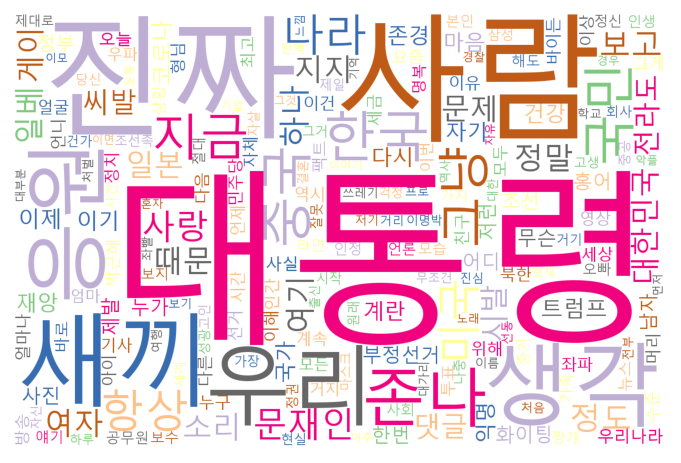

In [ ]:
# 악플여부 0인 워드클라우드 생성(normal_comment)
wordcloud = WordCloud(font_path = '/content/gdrive/My Drive/eda_data/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r",width=1500, height=1000).generate_from_frequencies(words) 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [ ]:
# 악플여부 2
# bad_comment
doc_ko = open('/content/gdrive/My Drive/eda_data/bad_comment.txt').read()
doc_ko

'지랄을 한다 역격리 고맙다\n지네때문에 온나라가 지랄낫는데\n짱꺄나 쪽바리나\n지랄한다미세먼지나 잡아라 중국에 말도 못하면서 말은 잘도 씨부린다\n아무리 내새끼라도 다리병신 만들어버렸을듯\nyeah 오늘도 잼민이가 한건 했구나 정말 미래가 밝다\n도대체 저자의 뒷백이 무엇일까 뭘 믿고 저 지랄일까 뭔가 믿는 구석이 단단히 있는걸\n술깨면 부끄러워 어쩔러구지랄이신지\n무엇이 그들을 죽음의ㅣ 이르게 했을까 욕심이다 택배는 기본적으로 동일지역에 다수의 택배기사가 일할수 있는 시스템이다 하지만 기사들은 동일지역 동일택배사에 다른 기사가 들어오는걸 원천봉쇄 하고 물량을 독점하길 원한다 한면만 보지마라 분류를 하지 않겠다고 그게 기업의 책임이라고 공무원의 나라를 기대하냐 대다수의 일반기업에서 야근수당 없이 야근을 하고 있다 그들이 병신인가 그들은 불행하냐 어찌 대기업과 공무원만 이나라에 존재하냐 JTBC도 점점 짜증이난다\n지랄도풍년이다 이시국에무신파티무신데이\n씹새끼 잘 보소\n동호회 젤 싫다 지들이 왕이야 지랄도\n지랄하고 자빠졌네\n옘병 시불\n공공시설을 사적으로 독점 이용 공무원은 다 알면서 재대로 업무처리 안 함 파면시켜야 함 개쓰레기 공무원과 동호회\n머저리도 아니고 떠난 사랑한테 머하는짓이야\n시민의식 짱깨 우뺨 갈겨버리네\n인성 ㅡㅡ즈그집불나면 지랄할것들이 ㅡㅡ\n또라이가 진짜 벌 받아라\n지랄도 가지가지\n지네 도로는 고요하다 어쩐다 언플 발광해대더니ㅋㅋㅋㅋㅋㅋ 정신병자의나라\n병신 헬멧을 안 쓰는 건 이유가 있구만 쓸데없는 걸 달고 있어서\n또라이새끼 아냐\n세상은 넓고 또라이는 많다\n저기도 바기지땜에 손님 떨어진데 아닌가 저런거 하지말고 인식부터 바꿔야지 돈지랄이네\n역시 짱깨\n걱정마라 간식거리 숨어서 찾는거다 짱깨들은 못먹는거없다\n지랄 나 껌 실수로 삼킨 적 개 많은데\n이카드 뉴스는 하이네켄 코리아의 지원을 받았습니다 잘한다 공중파가 ㅉㅉ그리고 하이네켄이야 당연히 사람이 많아져야 지들 술 많이 파니까 저런 거라도 하는거고 이태원은 된통 당해

In [ ]:
from konlpy.tag import Okt
t = Okt()
tokens_ko = t.nouns(doc_ko)
tokens_ko

['지랄',
 '역',
 '격리',
 '때문',
 '온나라',
 '지랄',
 '짱꺄',
 '쪽바리',
 '지랄',
 '미세먼지',
 '중국',
 '말',
 '말',
 '새끼',
 '다리',
 '병신',
 '오늘',
 '잼민',
 '건',
 '정말',
 '미래',
 '도대체',
 '저자',
 '백이',
 '무엇',
 '뭘',
 '저',
 '지랄',
 '뭔가',
 '구석',
 '술',
 '러',
 '지랄',
 '신지',
 '무엇',
 '그',
 '죽음',
 '욕심',
 '택배',
 '기본',
 '지역',
 '다수',
 '택배',
 '기사',
 '일',
 '시스템',
 '기사',
 '동일',
 '지역',
 '택배',
 '사',
 '다른',
 '기사',
 '원천',
 '봉쇄',
 '물량',
 '독점',
 '면',
 '분류',
 '그게',
 '기업',
 '책임',
 '공무원',
 '나라',
 '대다수',
 '기업',
 '야근',
 '수당',
 '야근',
 '그',
 '병신',
 '그',
 '어찌',
 '대기업',
 '공무원',
 '이나라',
 '존재',
 '도',
 '점점',
 '짜증',
 '지랄',
 '풍년',
 '시국',
 '파티',
 '데이',
 '새끼',
 '동호회',
 '젤',
 '왕',
 '지랄',
 '지랄',
 '옘병',
 '시불',
 '공공시설',
 '사적',
 '독점',
 '이용',
 '공무원',
 '재',
 '업무',
 '처리',
 '안',
 '함',
 '파면',
 '함',
 '개',
 '쓰레기',
 '공무원',
 '동호회',
 '머',
 '저리',
 '사랑',
 '머',
 '짓',
 '시민',
 '의식',
 '짱깨',
 '뺨',
 '인성',
 '집',
 '지랄',
 '또',
 '라이',
 '진짜',
 '벌',
 '지랄',
 '가지가지',
 '지네',
 '도로',
 '다',
 '언플',
 '더니',
 '정신병',
 '자의',
 '병신',
 '헬멧',
 '안',
 '건',
 '이유',
 '걸',
 '달',
 '또',
 '새끼',
 '세상',
 '또',


In [ ]:
# 두글자 이상만 뽑음
new_list = []
for word in tokens_ko:
    if len(word) >= 2:
        new_list.append(word)

In [ ]:
new_list

['지랄',
 '격리',
 '때문',
 '온나라',
 '지랄',
 '짱꺄',
 '쪽바리',
 '지랄',
 '미세먼지',
 '중국',
 '새끼',
 '다리',
 '병신',
 '오늘',
 '잼민',
 '정말',
 '미래',
 '도대체',
 '저자',
 '백이',
 '무엇',
 '지랄',
 '뭔가',
 '구석',
 '지랄',
 '신지',
 '무엇',
 '죽음',
 '욕심',
 '택배',
 '기본',
 '지역',
 '다수',
 '택배',
 '기사',
 '시스템',
 '기사',
 '동일',
 '지역',
 '택배',
 '다른',
 '기사',
 '원천',
 '봉쇄',
 '물량',
 '독점',
 '분류',
 '그게',
 '기업',
 '책임',
 '공무원',
 '나라',
 '대다수',
 '기업',
 '야근',
 '수당',
 '야근',
 '병신',
 '어찌',
 '대기업',
 '공무원',
 '이나라',
 '존재',
 '점점',
 '짜증',
 '지랄',
 '풍년',
 '시국',
 '파티',
 '데이',
 '새끼',
 '동호회',
 '지랄',
 '지랄',
 '옘병',
 '시불',
 '공공시설',
 '사적',
 '독점',
 '이용',
 '공무원',
 '업무',
 '처리',
 '파면',
 '쓰레기',
 '공무원',
 '동호회',
 '저리',
 '사랑',
 '시민',
 '의식',
 '짱깨',
 '인성',
 '지랄',
 '라이',
 '진짜',
 '지랄',
 '가지가지',
 '지네',
 '도로',
 '언플',
 '더니',
 '정신병',
 '자의',
 '병신',
 '헬멧',
 '이유',
 '새끼',
 '세상',
 '라이',
 '저기',
 '손님',
 '인식',
 '지랄',
 '역시',
 '짱깨',
 '걱정',
 '간식',
 '거리',
 '짱깨',
 '지랄',
 '실수',
 '카드',
 '뉴스',
 '하이네켄',
 '코리아',
 '지원',
 '공중파',
 '하이네켄',
 '사람',
 '저런',
 '이태원',
 '인천',
 '학원',
 '강사',
 '진자',
 '발생',
 '방역',
 '수칙',

In [ ]:
from collections import Counter
count = Counter(new_list)
count

Counter({'지랄': 1150,
         '격리': 3,
         '때문': 240,
         '온나라': 2,
         '짱꺄': 1,
         '쪽바리': 12,
         '미세먼지': 17,
         '중국': 423,
         '새끼': 3764,
         '다리': 24,
         '병신': 2707,
         '오늘': 38,
         '잼민': 10,
         '정말': 60,
         '미래': 32,
         '도대체': 39,
         '저자': 5,
         '백이': 1,
         '무엇': 31,
         '뭔가': 22,
         '구석': 50,
         '신지': 5,
         '죽음': 26,
         '욕심': 16,
         '택배': 32,
         '기본': 45,
         '지역': 51,
         '다수': 4,
         '기사': 64,
         '시스템': 34,
         '동일': 4,
         '다른': 99,
         '원천': 3,
         '봉쇄': 3,
         '물량': 9,
         '독점': 5,
         '분류': 5,
         '그게': 132,
         '기업': 81,
         '책임': 27,
         '공무원': 87,
         '나라': 394,
         '대다수': 17,
         '야근': 2,
         '수당': 2,
         '어찌': 26,
         '대기업': 24,
         '이나라': 12,
         '존재': 55,
         '점점': 26,
         '짜증': 7,
         '풍년': 21,
        

In [ ]:
# 빈도수 높은 것만 추출
words = dict(count.most_common())
words

{'새끼': 3764,
 '병신': 2707,
 '짱깨': 1451,
 '지랄': 1150,
 '씨발': 1043,
 '진짜': 664,
 '개새끼': 654,
 '존나': 628,
 '사람': 576,
 '한국': 557,
 '미국': 517,
 '그냥': 497,
 '생각': 454,
 '중국': 423,
 '시발': 422,
 '소리': 406,
 '일베': 406,
 '나라': 394,
 '빨갱이': 393,
 '홍어': 382,
 '지금': 378,
 '재앙': 340,
 '트럼프': 333,
 '개좆': 307,
 '쓰레기': 304,
 '하나': 304,
 '대가리': 302,
 '전라도': 285,
 '조선족': 277,
 '문재인': 262,
 '중공': 260,
 '보지': 250,
 '일본': 244,
 '국민': 243,
 '때문': 240,
 '국가': 234,
 '짱개': 234,
 '보고': 232,
 '박근혜': 224,
 '좌좀': 220,
 '수준': 218,
 '우리': 215,
 '정도': 210,
 '대통령': 210,
 '좌파': 208,
 '바이든': 206,
 '부정선거': 205,
 '짱꼴라': 204,
 '대한민국': 200,
 '우파': 197,
 '거지': 196,
 '문제': 194,
 '댓글': 193,
 '조선': 189,
 '무슨': 188,
 '정치': 185,
 '이제': 184,
 '여자': 184,
 '저런': 178,
 '보수': 175,
 '자기': 174,
 '자체': 171,
 '팩트': 170,
 '좆족': 169,
 '니애미': 169,
 '북한': 168,
 '사실': 165,
 '바로': 160,
 '민주당': 158,
 '인간': 150,
 '한족': 149,
 '시진핑': 148,
 '선동': 148,
 '누가': 141,
 '모두': 140,
 '영어': 140,
 '정신병': 136,
 '그게': 132,
 '창년': 131,
 '저능': 129,
 '한번': 128,
 '가

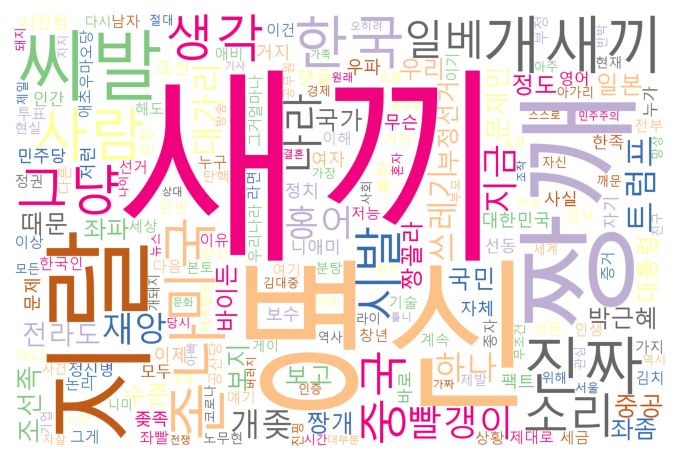

In [ ]:
# 악플여부 2인 워드클라우드 생성(bad_comment)
wordcloud = WordCloud(font_path = '/content/gdrive/My Drive/eda_data/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r",width=1500, height=1000).generate_from_frequencies(words) 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


**악플여부 0인 데이터에서도 욕설이 포함된것을 알 수 있음. 따라서 악플여부 0인 데이터를 직접 사람이 판단하여 라벨링을 해주기로 함.**

## 댓글 길이 확인

In [ ]:
# 댓글길이 컬럼 추가 및 최대길이 확인
preprocessing_df['댓글길이'] = preprocessing_df['댓글'].apply(lambda x : len(str(x)))
preprocessing_df['댓글길이'].max()

1978

In [ ]:
# 댓글길이 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [ ]:
len_int = preprocessing_df['댓글길이'].astype(int)
len_sort = len_int.sort_values()
print(len_sort)
sort_df = pd.DataFrame(len_sort)

len_count = pd.DataFrame(sort_df.groupby(['댓글길이']).size())
print(len_count)
print(len_count.columns)
len_count.columns = ['댓글개수']
len_count

6250        1
34660       1
34682       1
6999        1
20668       1
         ... 
35050    1812
15784    1846
17426    1921
26901    1945
17952    1978
Name: 댓글길이, Length: 92063, dtype: int64
         0
댓글길이      
1       19
2       56
3      148
4      515
5     1445
...    ...
1812     1
1846     1
1921     1
1945     1
1978     1

[739 rows x 1 columns]
RangeIndex(start=0, stop=1, step=1)


댓글개수
댓글길이      
1       19
2       56
3      148
4      515
5     1445
...    ...
1812     1
1846     1
1921     1
1945     1
1978     1

[739 rows x 1 columns]

In [ ]:
len_count.reset_index(level=0, inplace=True)
print(len_count)

     댓글길이  댓글개수
0       1    19
1       2    56
2       3   148
3       4   515
4       5  1445
..    ...   ...
734  1812     1
735  1846     1
736  1921     1
737  1945     1
738  1978     1

[739 rows x 2 columns]


In [ ]:
len_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   댓글길이    739 non-null    int64
 1   댓글개수    739 non-null    int64
dtypes: int64(2)
memory usage: 11.7 KB


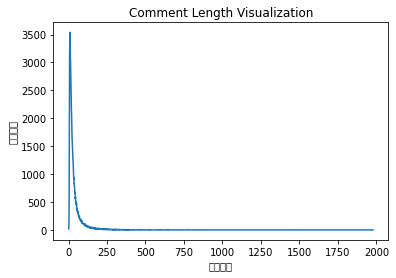

In [ ]:
plt.title('Comment Length Visualization')
plt.plot(len_count['댓글길이'], len_count['댓글개수']) #앞이 x축, 뒤가 y축
plt.xlabel('댓글길이')
plt.ylabel('댓글개수')
plt.show()

In [ ]:
# 댓글길이 500자 이하
len_count2 = len_count[len_count['댓글길이'] <= 500]
len_count2

댓글길이  댓글개수
0       1    19
1       2    56
2       3   148
3       4   515
4       5  1445
..    ...   ...
475   495     1
476   496     1
477   497     2
478   499     1
479   500     4

[480 rows x 2 columns]

In [ ]:
plt.title('Comment Length Visualization')
plt.plot(len_count2['댓글길이'], len_count2['댓글개수']) #앞이 x축, 뒤가 y축
plt.xlabel('댓글길이')
plt.ylabel('댓글개수')
plt.show()

In [ ]:
# 댓글길이 200 이상 1000자 이하
len_count3 = len_count[(len_count['댓글길이'] <= 1000) & (len_count['댓글길이'] >= 200)]
len_count3

댓글길이  댓글개수
199   200    18
200   201    19
201   202    24
202   203    12
203   204    22
..    ...   ...
705   952     2
706   955     1
707   958     1
708   960     1
709   992     1

[511 rows x 2 columns]

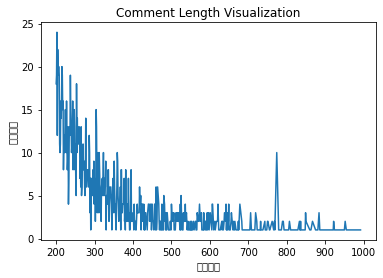

In [ ]:
x = len_count3['댓글길이']
y = len_count3['댓글개수']
plt.title('Comment Length Visualization')
plt.plot(x,y) #앞이 x축, 뒤가 y축
plt.xlabel('댓글길이')
plt.ylabel('댓글개수')
plt.show()

In [ ]:
# 추세선 추가 - 선형회귀 피팅
import seaborn as sns
plt.title('Comment Length Visualization')
sns.regplot(x,y,len_count3,fit_reg=True)

In [ ]:
# 추세선 추가 - 최소제곱법을 이용한 추세선
z = np.polyfit(x,y,1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.plot(x,y)
plt.title('Comment Length Visualization')

Text(0.5, 1.0, 'Comment Length Visualization')

**이상치찾기**

In [ ]:
# 이상치 찾기
# 댓글길이 700 이상 800자 이하
len_count_out = len_count[(len_count['댓글길이'] <= 800) & (len_count['댓글길이'] >= 700)]
print(len_count_out['댓글개수'].max())
# len_count_out['댓글개수']==10
print(len_count_out['댓글길이'][len_count_out['댓글개수']==10])

10
647    774
Name: 댓글길이, dtype: int64


In [ ]:
preprocessing_df.head()
outlier = preprocessing_df[preprocessing_df['댓글길이']==774]
print(len(outlier))
display(outlier)
print('\n')
print(outlier.iloc[0,0])

10


댓글 악플여부  댓글길이
108049  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774
108061  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774
108063  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774
108064  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774
108066  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774
108077  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774
108087  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774
108113  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774
108121  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774
108136  니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 ...    2   774



니미씹에 짱꼴라가 만선이 되서 니같은 짱꼴라 씨입새끼가 기 나왔담서 니같은 짱꼴라 혼종이 기 나왔는데 병신같은 니에비는 좋다고 미역사러 시장에 갔담서 이 쳐 죽일 새꺄 확 씨발새끼 야샵으로 죽통을 날리뿔라너 우마오당 소속 대깨문이고 한족이지못하지 개병신 한족 쓰레기 새끼 제에발 니네 본토에가서 뒈져 씨발련들아자 개소리 말고 이것 부터 따라 해 쉬워 ㅋ 한국인이라면 웃으면서누구라도 복붙 할수 있는거야그런데 하지 않고 헛 소리와 변명을 늘어놓은것 전부다 중공 우마오당 개좆들이지 코너에 몰려 일부 따라하는 한족들이 있지만 ㅋㅋ 그런것을 모두 화면켑춰해서 우마오당 한족 집합처에보여주면 크크크크크 자 암튼 따라해봐따라 해봐 짱꼴라 씨입새꺄 ㅋㅋWhat is Xi Jinpings assassination plan Tell me you want to assassinate Xi Jinping시진핑총리 암살 계획은 무엇인가 Xi Jinping을 암살하고 싶다고 말해줘
Kang Taekmin is the enemy of the people to kill Mao must also Open the coffin and take out the body and then Decompose and destroypls kill ALL the CCPwe all human must destroy and decompose all the CCP peoples강택민도쳐죽여야할 인민과 의 적이다 또 마오쩌뚱은 부관참시를 해야 한다 중국 공산당들은 모조리 살처분 시켜야 한다 아예 종자자체를 말살 시켜야 해ㅋ


In [ ]:
# 위의 이상치 댓글의 출처 찾기
display(source_df.head())
display(source_df[source_df['댓글']==outlier.iloc[0,0]])
print(source_df[source_df['댓글']==outlier.iloc[0,0]].iloc[0,3])

Unnamed: 0  ...                               출처
1           1  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
2           2  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
3           3  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
4           4  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv
5           5  ...  ./data\JTBCNEWS_인스타_댓글_1116.csv

[5 rows x 4 columns]

Unnamed: 0  ...                                 출처
108049       47888  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv
108061       47900  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv
108063       47902  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv
108064       47903  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv
108066       47905  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv
108077       47916  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv
108087       47926  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv
108113       47952  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv
108121       47960  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv
108136       47975  ...  ./data\일베_일간베스트게시물_댓글_최근12페이지.csv

[10 rows x 4 columns]

./data\일베_일간베스트게시물_댓글_최근12페이지.csv


=> 이상치의 출처는 일간베스트이고 중복된 댓글임을 알수 있음.

## 악플여부 0인 댓글중 400자 이상인 댓글만 라벨링 진행함

In [ ]:
# 400자 이상인 댓글 데이터 추출
need_label = normal_comment[normal_comment['댓글길이'] < 400]
need_label

댓글 악플여부  댓글길이
1       심각허다 법안 검토도 안 하는 의원들 내 세금으로 호의호식 한다 생각하니까 열받네 ...    0    60
2       차도에서 25km제한 둠 어쩌자는건지 자전거 오토바이도 그거보다 빠르다 인도 차도 ...    0   132
3                                     국회의원직 다 박탈했으면 좋겠네ㅠㅠ    0    19
4                                      표 얻을 생각 말고 법을 만들어라    0    18
5                            초딩 애들이 몰고다니는 형형색색 씽씽이 생각했나보네    0    28
...                                                   ...  ...   ...
127118                                            오빠 어디예요    0     7
127119                                             외국 갔어요    0     6
127121                               이건 홍마담에서 구입 못하나요 ㅎㅎㅎ    0    20
127122                                         느무 잘먹는 예 9    0    10
127123                             맛있는건 눈으로만 봐도 알죠맛있게 드세요    0    22

[82792 rows x 3 columns]

In [ ]:
# 우리가 직접 라벨링 후 EDA
human_label = pd.read_csv('/content/gdrive/My Drive/eda_data/human_label.csv')
label_count = human_label.groupby(['악플여부']).size()
label_count_df = pd.DataFrame(label_count)
label_count_df.columns = ['개수']
label_count_df.head()

개수
악플여부       
0.0   67399
1.0    5620
2.0    8262

In [ ]:
label_count_df.index = ['일반댓글(0)', '악성위험댓글(1)', '악성댓글(2)']
label_count_df.head()

개수
일반댓글(0)    67399
악성위험댓글(1)   5620
악성댓글(2)     8262

In [ ]:
# 인덱스 조정
label_count_df.reset_index(level=0, inplace=True)

In [ ]:
label_count_df.columns = ['댓글분류', '개수']
label_count_df.head()

댓글분류     개수
0    일반댓글(0)  67399
1  악성위험댓글(1)   5620
2    악성댓글(2)   8262

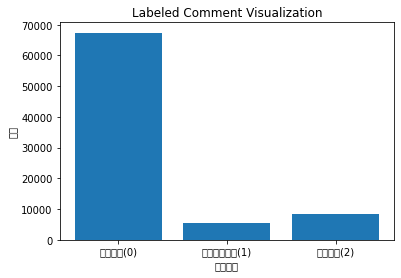

In [ ]:
plt.title('Labeled Comment Visualization')
plt.bar(label_count_df['댓글분류'], label_count_df['개수']) #앞이 x축, 뒤가 y축
plt.xlabel('댓글분류')
plt.ylabel('개수')
plt.show()

## 워드클라우드(라벨링한거)

In [ ]:
human_label

Unnamed: 0                                                 댓글  악플여부
0               0                                                 U2   0.0
1               1                                                 2기   0.0
2               2                                                 5빵   0.0
3               3                                                 2등   0.0
4               4                                                 1둥   0.0
...           ...                                                ...   ...
81276       81276  기안 작품 자체가 정치색은 없고 그 시대의 사회비판 요소가 존나 강했음기안 초창기 ...   0.0
81277       81277  일베에서 분탕치던 틈루새 조선족 바퀴벌레 들 총출동해서 발악하는거 봐라니들이 아무리...   0.0
81278       81278  함소원씨를 그래도 좋아하는마음으로 아내의맛 애청자인데 참 안타깝네요 이모님께 존댓말...   1.0
81279       81279  해마다 걷히는세금 똑같다 늘겠냐 수입과지출인데 걷히는금액 공표하고 어디다쓴느지 표기...   0.0
81280       81280  일을 조금이라도 줄이시고 혜정이와 함께하는 시간을 좀 더 늘리는게 어떨까요 돈도 좋...   0.0

[81281 rows x 3 columns]

In [ ]:
# 악플여부 0,1,2 로 데이터 나눔
label_zero = human_label[human_label['악플여부']==0]
label_one = human_label[human_label['악플여부']==1]
label_two = human_label[human_label['악플여부']==2]
display(label_one)


Unnamed: 0                                                 댓글  악플여부
18             18                                                돌았0   1.0
19             19                                                또라2   1.0
31             31                                               와 시바   1.0
38             38                                               와 씨바   1.0
39             39                                               아 시발   1.0
...           ...                                                ...   ...
81245       81245  고문은 조선시대가 더 했지 영화 보면 왕이 직접 고문친국하질 않나넌 후궁 간신같은 ...   1.0
81248       81248  음 저도 아기엄마지만 일하면서 키우는데 다른건 몰라도 아이 아플땐 엄마 밖에 없어요...   1.0
81265       81265  이재용 ㅂㅅㅅㄲ 부임하자마자 한짓거리가 일체형 따라가기였음5년간 앱등이 거리면서 욕...   1.0
81272       81272  자그마치 기원전 30세기에 서양 문화권에서는 전기로 금 도금한 유물 발굴로 전기 건...   1.0
81278       81278  함소원씨를 그래도 좋아하는마음으로 아내의맛 애청자인데 참 안타깝네요 이모님께 존댓말...   1.0

[5620 rows x 3 columns]

In [ ]:
# 각각 txt파일로 저장
zero = label_zero['댓글']
zero.to_csv('/content/gdrive/My Drive/eda_data/label_zero.txt', sep = '\t', index=False)
one = label_one['댓글']
one.to_csv('/content/gdrive/My Drive/eda_data/label_one.txt', sep = '\t', index=False)
two = label_two['댓글']
two.to_csv('/content/gdrive/My Drive/eda_data/label_two.txt', sep = '\t', index=False)


In [ ]:
# label_zero (일반댓글)
doc_ko = open('/content/gdrive/My Drive/eda_data/label_zero.txt').read()
doc_ko

'댓글\nU2\n2기\n5빵\n2등\n1둥\n개 꿀\n5호선\n큰 잠\n5호선\n5호선\n쩝 쩝\nㄲ ㅑ\n코 란\n걐 퉷\n5호선\n눈 봐\n하 ㅜ\nㅜ ㅜ\n삶 삶\n헐 껌\n5호선\n꼭 봐\n존 싫\n쩐 다\n걍 사\n오 구미\n캬악 퉷\n오 드뎌\n헐 ㅜㅜ\n아 역시\n윽 프로\n젓갈 놉\n떼잉 쯧\n아 ㅡㅡ\n준비 2\n좋다 ㅋ\n엥 대전\n헉 미친\n3분동안\n헐 미친\n사진 쩔\n역 겹다\n헐 대박\n에이 퉤\n껌 바이\n아 뭐랭\n후 빡쳐\n참 곱다\n계정 앎\n껌 고만\n껌 안녕\n12살껄\n광고 각\n와우 비\n헐 대박\n오 내년\n광고 ㄷ\n이거 봐\n형 힘내\n응 광고\n헐 비다\n이거 봐\n와 억장\n와 대박\n와 미친\n현실U2\n진짜 하\nU2 오\n윽 으윽\n와 대박\n와 ㄹㅇ\n탈모 빔\n더 강함\n와 진짜\n캬악 투\n와 개꿀\n아 ㅋㅋ\n계란 짱\n와 쩌러\n와 미친\n5호선야\n쏘 유익\n와 대박\n와 대박\n30테라\n헐 대박\n와 이걸\n30테라\n사줘 ㅜ\n옹 싱기\n진짜 비\n이제 암\nㅘ 꿀팁\n제발 좀\n잘 했어\n넌 아나\n선 넘네\n오 대박\n귀 조심\n오 꿀팁\n와 명언\n와 쩐다\n올 굼미\n쉩 천국\n뽀얀 개란\n조합 ㄷㄷ\n머해 거서\n장ㅇ ㅇ샊\n의사 박씨\n건치 ㄷㄷ\n오 야광충\n형 나죽어\n어여 사와\n와 김종국\n빵 사온나\n레깅스 핏\n쉬지 ㅠㅠ\n너도 들어\n귀여웡 ㅠ\n반숙 직전\n건치 미남\n밥 아저씨\n귀 엽 다\n와 레전드\n귀여웡 퓨\n와 미쳤다\n짱멋 존멋\n헐 김종쿡\n형 사랑해\n예쁜 계란\n뭔 프로죵\n치열 곱네\n악넘 큐티\n곱다 고와\n메일이 빡\n내 이상형\n와 참ㄴㅏ\n손절 ㅅㄱ\n와 드디어\n오우 와우\n정답 쏘우\n대박 키키\n형 사랑해\n와 ㄷ ㄷ\nㅁㅊ ㅋㅋ\n힘 힘 힘\n빠그 빠그\n머선129\n귀엽다 하\n문프 천세\n어 주호민\n익은 계란\n와 스케일\n지겹다 문\n오 쒸이잇\n건치 공개\n미백 계란\n와 드디어\n뭐야 졸귀\n당연한 걸\n계란 콩쿨\n와 

In [ ]:
from konlpy.tag import Okt
t = Okt()
tokens_ko = t.nouns(doc_ko)
tokens_ko

['댓글',
 '기',
 '빵',
 '둥',
 '개',
 '꿀',
 '호선',
 '잠',
 '호선',
 '호선',
 '코',
 '란',
 '걐',
 '퉷',
 '호선',
 '눈',
 '삶',
 '삶',
 '껌',
 '호선',
 '꼭',
 '존',
 '쩐',
 '사',
 '오',
 '구미',
 '캬악',
 '퉷',
 '오',
 '드뎌',
 '역시',
 '윽',
 '프로',
 '젓갈',
 '놉',
 '떼잉',
 '준비',
 '대전',
 '사진',
 '쩔',
 '역',
 '겹',
 '대박',
 '에이',
 '퉤',
 '껌',
 '바이',
 '뭐랭',
 '후',
 '계정',
 '껌',
 '껌',
 '안녕',
 '살껄',
 '광고',
 '각',
 '와우',
 '비',
 '대박',
 '오',
 '내년',
 '광고',
 '거',
 '형',
 '응',
 '광고',
 '비',
 '거',
 '장',
 '대박',
 '현실',
 '진짜',
 '오',
 '윽',
 '대박',
 '탈모',
 '빔',
 '더',
 '진짜',
 '캬악',
 '투',
 '개꿀',
 '계란',
 '짱',
 '호선',
 '유익',
 '대박',
 '대박',
 '테라',
 '대박',
 '걸',
 '테라',
 '옹',
 '싱기',
 '진짜',
 '비',
 '이제',
 '암',
 '꿀팁',
 '제발',
 '좀',
 '넌',
 '아',
 '선',
 '오',
 '대박',
 '귀',
 '조심',
 '오',
 '꿀팁',
 '명언',
 '쩐다',
 '굼미',
 '쉩',
 '천국',
 '조합',
 '머',
 '거',
 '장',
 '샊',
 '의사',
 '박씨',
 '건치',
 '오',
 '야광충',
 '형',
 '나',
 '김종국',
 '빵',
 '레깅스',
 '핏',
 '쉬',
 '너',
 '귀여웡',
 '반숙',
 '직전',
 '건치',
 '미남',
 '밥',
 '아저씨',
 '귀',
 '엽',
 '레전드',
 '귀여웡',
 '퓨',
 '멋',
 '존멋',
 '김종',
 '쿡',
 '형',
 '사랑',
 '계란',
 '프로'

In [ ]:
new_list = []
for word in tokens_ko:
    if len(word) >= 2:
        new_list.append(word)

In [ ]:
new_list

['댓글',
 '호선',
 '호선',
 '호선',
 '호선',
 '호선',
 '구미',
 '캬악',
 '드뎌',
 '역시',
 '프로',
 '젓갈',
 '떼잉',
 '준비',
 '대전',
 '사진',
 '대박',
 '에이',
 '바이',
 '뭐랭',
 '계정',
 '안녕',
 '살껄',
 '광고',
 '와우',
 '대박',
 '내년',
 '광고',
 '광고',
 '대박',
 '현실',
 '진짜',
 '대박',
 '탈모',
 '진짜',
 '캬악',
 '개꿀',
 '계란',
 '호선',
 '유익',
 '대박',
 '대박',
 '테라',
 '대박',
 '테라',
 '싱기',
 '진짜',
 '이제',
 '꿀팁',
 '제발',
 '대박',
 '조심',
 '꿀팁',
 '명언',
 '쩐다',
 '굼미',
 '천국',
 '조합',
 '의사',
 '박씨',
 '건치',
 '야광충',
 '김종국',
 '레깅스',
 '귀여웡',
 '반숙',
 '직전',
 '건치',
 '미남',
 '아저씨',
 '레전드',
 '귀여웡',
 '존멋',
 '김종',
 '사랑',
 '계란',
 '프로',
 '치열',
 '큐티',
 '메일',
 '이상형',
 '손절',
 '오우',
 '와우',
 '정답',
 '쏘우',
 '대박',
 '키키',
 '사랑',
 '빠그',
 '빠그',
 '머선',
 '문프',
 '천세',
 '주호민',
 '계란',
 '스케일',
 '쒸이잇',
 '건치',
 '공개',
 '미백',
 '계란',
 '졸귀',
 '계란',
 '콩쿨',
 '엄지',
 '우뚝',
 '화이팅',
 '계란',
 '쏘우',
 '야근',
 '대위',
 '수사',
 '물리',
 '아우',
 '계란',
 '위풍',
 '댕댕',
 '몰랏다',
 '개싱기',
 '언니',
 '꿀팁',
 '박해',
 '사랑',
 '개쥬',
 '꿀팁',
 '히잉',
 '눈물',
 '상생',
 '글쎄',
 '낄낄',
 '빠빠',
 '머싱성',
 '하나',
 '사라',
 '역시',
 '중국',
 '주제',
 '매각',
 '난리',
 '기억'

In [ ]:
from collections import Counter
count = Counter(new_list)
count

Counter({'댓글': 626,
         '호선': 122,
         '구미': 19,
         '캬악': 3,
         '드뎌': 24,
         '역시': 397,
         '프로': 241,
         '젓갈': 49,
         '떼잉': 2,
         '준비': 135,
         '대전': 39,
         '사진': 479,
         '대박': 210,
         '에이': 18,
         '바이': 22,
         '뭐랭': 1,
         '계정': 75,
         '안녕': 30,
         '살껄': 4,
         '광고': 202,
         '와우': 97,
         '내년': 200,
         '현실': 209,
         '진짜': 2582,
         '탈모': 22,
         '개꿀': 50,
         '계란': 704,
         '유익': 2,
         '테라': 59,
         '싱기': 2,
         '이제': 562,
         '꿀팁': 24,
         '제발': 494,
         '조심': 79,
         '명언': 14,
         '쩐다': 29,
         '굼미': 1,
         '천국': 48,
         '조합': 82,
         '의사': 106,
         '박씨': 6,
         '건치': 13,
         '야광충': 1,
         '김종국': 21,
         '레깅스': 4,
         '귀여웡': 21,
         '반숙': 6,
         '직전': 23,
         '미남': 17,
         '아저씨': 108,
         '레전드': 59,
         '존멋': 5,
 

In [ ]:
words = dict(count.most_common())
words

{'대통령': 4102,
 '사람': 2936,
 '진짜': 2582,
 '응원': 2017,
 '우리': 1926,
 '생각': 1748,
 '항상': 1474,
 '국민': 1172,
 '사랑': 1136,
 '한국': 1114,
 '그냥': 1109,
 '지금': 1106,
 '중국': 1058,
 '미국': 1009,
 '나라': 971,
 '문재인': 953,
 '여기': 831,
 '정말': 804,
 '보고': 784,
 '정도': 781,
 '지지': 779,
 '하나': 765,
 '계란': 704,
 '건강': 674,
 '때문': 664,
 '존경': 654,
 '대한민국': 646,
 '문제': 643,
 '코로나': 640,
 '댓글': 626,
 '일본': 612,
 '일베': 606,
 '존나': 603,
 '화이팅': 593,
 '트럼프': 593,
 '마음': 591,
 '여자': 583,
 '이제': 562,
 '소리': 547,
 '다시': 521,
 '익명': 517,
 '오늘': 514,
 '게이': 496,
 '제발': 494,
 '자기': 491,
 '사진': 479,
 '우리나라': 465,
 '무슨': 464,
 '어디': 461,
 '누가': 455,
 '부정선거': 444,
 '한번': 442,
 '언니': 440,
 '남자': 435,
 '요즘': 433,
 '방송': 428,
 '세상': 418,
 '정부': 416,
 '형님': 410,
 '명복': 408,
 '최고': 406,
 '사실': 405,
 '기사': 402,
 '저런': 400,
 '역시': 397,
 '이건': 396,
 '오빠': 394,
 '국가': 394,
 '위해': 392,
 '시간': 387,
 '이유': 384,
 '새끼': 378,
 '얼마나': 373,
 '머리': 371,
 '계속': 371,
 '얼굴': 370,
 '바이든': 369,
 '언제': 368,
 '인간': 365,
 '영상': 365,
 '친구': 353,
 

In [ ]:
# 일반댓글 워드클라우드 생성
wordcloud = WordCloud(font_path = '/content/gdrive/My Drive/eda_data/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r",width=1500, height=1000).generate_from_frequencies(words) 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [ ]:
# label_one (악성위험댓글)
doc_ko = open('/content/gdrive/My Drive/eda_data/label_one.txt').read()
doc_ko

'댓글\n돌았0\n또라2\n와 시바\n와 씨바\n아 시발\n하 쓰바\n으 역겨워\n너무 싫다\n너 미쳤니\nㅁㅊ ㅡㅡ\n재앙 ㅇㅂ\n아 욕나와\n진짜 싫다\n대 깨 문\n아오 시팔\n좆갈 ㅋㅋ\n문죄인 심판\n뻔뻔 스럽다\n아진짜 시발\n에바임 ㅅㅂ\n짱개들 진짜\nㅈㄹ을 한다\nㅂㅅ육갑 주접\n삶은 X대가리\n미틴넘 재앙이\n똥 보다도싫음\n흙수저 미쳤나\n아 18 ㅡㅡ\nㅅㅂ 개빡친다\n중국으로 꺼져\n홧김 미쳤나봐\n정신 못차렸네\n니취팔러마 휴\n걍 조용히살지\n와씨 개드러워\n아내눈 버렸노\n아 가증스러워\n쓰레기 독재자\n야동 공유한듯\n합방 각인가요\n재앙재앙 대재앙\n재앙 재앙 재앙\n재앙이 개씌방세\n재앙이다 ㄷㄷㄷ\n깨문이들 많구나\n문빠들 천국이네\n무능하다 증말루\n도랏 ㅎ ㅓ ㄹ\n미친거 아닌가요\n시발롬아 하야해\n미쳤다 진짜ㅡㅡ\n아오 씨발 진짜\nㅡㅡ 정상이없네\n싯팔 존나 빡쳐\n이 나라 젓까네\n이 미친 것들이\nㅅㅂ ㅠ 성안동\n하하다하다 진짜\n와ㅈㅓ런 쓰레기\n문재인 개양아치\n쑈를 하네ㅋㅋㅋ\n아 ㅈㅎㄴ나빡쳐\nㄹㅇ 답이 없네\n얘네 답도 없다\n존나 싫다 문제인\n왜 살려둬야하는가\n대깨들이 판을치네\n문빠구리 문코로나\n진짜 개 븅신이네\n도랏나 중국닝겐들\n하 개빡치네 시벌\n기생충같은 문시끼\n개빨걍이 히발솨끼\n이게 뭔 개소리임\n미친 아니 욕나와\n그냥 무능 그자체\n아니 안놀면 죽냐\n문빠탈출은 지능순\n고생한다 군바리쉑\n걍 찌그러져 있어\n진짜 징하다 구치\n개히바락 뻘건쇠키\n재앙 재앙 대재앙\n얘가 자꾸 선넘네\n소통ㅁㅊㅅㄲ ㅡㅡ\n일 열심히 하는척\n여친있는 김부랄씨\n쇼문괴질 체포 사형\n김치맨 ㅋㅋㅋㅋㅋㅋ\n오줌은 누고 다니냐\n짱개는 역시 쓰레기\n언론 플레이 역겹다\n이게 뭔 개쌉소리야\n퀵라니들 진짜 노답\n디엠 쳐봐 시발롬아\n대가리깨지신분 많넹\n곶짜사나이 아 오타\n쳐웃고자빠졌네 ㅋㅋ\n개때리고 싶다 진짜\n재앙이노 나라꼴 좀\n뭐지 시체썩는 냄새\n대깨킥 3콤보 영상\n애색끼 뺨따구를

In [ ]:
from konlpy.tag import Okt
t = Okt()
tokens_ko = t.nouns(doc_ko)
tokens_ko

['댓글',
 '또',
 '시바',
 '씨바',
 '시발',
 '바',
 '너',
 '재앙',
 '욕',
 '진짜',
 '깨',
 '문',
 '팔',
 '좆',
 '문죄인',
 '심판',
 '뻔뻔',
 '진짜',
 '시발',
 '에바',
 '임',
 '짱개',
 '진짜',
 '육갑',
 '주접',
 '대가리',
 '틴',
 '재앙',
 '똥',
 '흙',
 '수저',
 '개',
 '중국',
 '홧김',
 '정신',
 '취',
 '살',
 '씨',
 '개',
 '아내',
 '눈',
 '가증',
 '쓰레기',
 '독재자',
 '야동',
 '공유',
 '듯',
 '합방',
 '각',
 '재앙',
 '재앙',
 '대재앙',
 '재앙',
 '재앙',
 '재앙',
 '재앙',
 '개씌방세',
 '재앙',
 '빠',
 '천국',
 '증말루',
 '도랏',
 '시발롬',
 '하야',
 '진짜',
 '씨발',
 '진짜',
 '정상',
 '싯팔',
 '존나',
 '이',
 '나라',
 '이',
 '것',
 '성안동',
 '하하',
 '진짜',
 '런',
 '쓰레기',
 '문재인',
 '개',
 '아치',
 '쑈',
 '나',
 '답',
 '얘',
 '답',
 '존나',
 '문제',
 '왜',
 '깨',
 '빠구리',
 '코로나',
 '진짜',
 '개',
 '븅신',
 '도랏',
 '중국',
 '닝겐',
 '개',
 '시벌',
 '기생충',
 '끼',
 '개빨',
 '발솨끼',
 '이',
 '개',
 '소리',
 '임',
 '욕',
 '그냥',
 '무능',
 '자체',
 '빠',
 '탈출',
 '지능',
 '순',
 '고생',
 '군',
 '바리',
 '쉑',
 '진짜',
 '징',
 '구치',
 '바락',
 '뻘건쇠키',
 '재앙',
 '재앙',
 '대재앙',
 '얘',
 '자꾸',
 '선',
 '소통',
 '일',
 '척',
 '여친',
 '김부',
 '랄',
 '쇼',
 '괴질',
 '체포',
 '사형',
 '김치',
 '맨',
 '오줌',
 '누',
 '짱개',
 '역시'

In [ ]:
new_list = []
for word in tokens_ko:
    if len(word) >= 2:
        new_list.append(word)

In [ ]:
new_list

['댓글',
 '시바',
 '씨바',
 '시발',
 '재앙',
 '진짜',
 '문죄인',
 '심판',
 '뻔뻔',
 '진짜',
 '시발',
 '에바',
 '짱개',
 '진짜',
 '육갑',
 '주접',
 '대가리',
 '재앙',
 '수저',
 '중국',
 '홧김',
 '정신',
 '아내',
 '가증',
 '쓰레기',
 '독재자',
 '야동',
 '공유',
 '합방',
 '재앙',
 '재앙',
 '대재앙',
 '재앙',
 '재앙',
 '재앙',
 '재앙',
 '개씌방세',
 '재앙',
 '천국',
 '증말루',
 '도랏',
 '시발롬',
 '하야',
 '진짜',
 '씨발',
 '진짜',
 '정상',
 '싯팔',
 '존나',
 '나라',
 '성안동',
 '하하',
 '진짜',
 '쓰레기',
 '문재인',
 '아치',
 '존나',
 '문제',
 '빠구리',
 '코로나',
 '진짜',
 '븅신',
 '도랏',
 '중국',
 '닝겐',
 '시벌',
 '기생충',
 '개빨',
 '발솨끼',
 '소리',
 '그냥',
 '무능',
 '자체',
 '탈출',
 '지능',
 '고생',
 '바리',
 '진짜',
 '구치',
 '바락',
 '뻘건쇠키',
 '재앙',
 '재앙',
 '대재앙',
 '자꾸',
 '소통',
 '여친',
 '김부',
 '괴질',
 '체포',
 '사형',
 '김치',
 '오줌',
 '짱개',
 '역시',
 '쓰레기',
 '언론',
 '플레이',
 '소리',
 '진짜',
 '노답',
 '디엠',
 '시발롬',
 '대가리',
 '신분',
 '많넹',
 '사나이',
 '오타',
 '진짜',
 '재앙',
 '이노',
 '나라',
 '시체',
 '냄새',
 '깨킥',
 '콤보',
 '영상',
 '애색끼',
 '치기',
 '우리',
 '게이물',
 '대통령',
 '나라',
 '죄인',
 '샹것들',
 '벌금',
 '정신',
 '아주',
 '쑈를하',
 '쑈를해',
 '염병',
 '풍년',
 '혼자',
 '북한',
 '가라',
 '제발',
 '보기',
 '소통',
 '진심

In [ ]:
from collections import Counter
count = Counter(new_list)
count

Counter({'댓글': 63,
         '시바': 17,
         '씨바': 9,
         '시발': 121,
         '재앙': 313,
         '진짜': 328,
         '문죄인': 16,
         '심판': 4,
         '뻔뻔': 1,
         '에바': 2,
         '짱개': 150,
         '육갑': 1,
         '주접': 6,
         '대가리': 46,
         '수저': 8,
         '중국': 183,
         '홧김': 6,
         '정신': 53,
         '아내': 12,
         '가증': 2,
         '쓰레기': 37,
         '독재자': 4,
         '야동': 22,
         '공유': 4,
         '합방': 1,
         '대재앙': 5,
         '개씌방세': 1,
         '천국': 7,
         '증말루': 1,
         '도랏': 3,
         '시발롬': 2,
         '하야': 7,
         '씨발': 77,
         '정상': 24,
         '싯팔': 3,
         '존나': 662,
         '나라': 140,
         '성안동': 1,
         '하하': 2,
         '문재인': 67,
         '아치': 9,
         '문제': 67,
         '빠구리': 12,
         '코로나': 36,
         '븅신': 9,
         '닝겐': 1,
         '시벌': 7,
         '기생충': 5,
         '개빨': 1,
         '발솨끼': 1,
         '소리': 136,
         '그냥': 155,
         '무능': 3,

In [ ]:
words = dict(count.most_common())
words

{'존나': 662,
 '새끼': 536,
 '이기': 333,
 '진짜': 328,
 '재앙': 313,
 '사람': 265,
 '게이': 228,
 '중국': 183,
 '홍어': 171,
 '전라도': 161,
 '생각': 158,
 '그냥': 155,
 '한국': 155,
 '짱개': 150,
 '나라': 140,
 '소리': 136,
 '일베': 133,
 '미국': 128,
 '시발': 121,
 '좌빨': 119,
 '좌파': 114,
 '국민': 112,
 '지금': 107,
 '대통령': 101,
 '여자': 100,
 '정도': 85,
 '수준': 83,
 '조선': 80,
 '때문': 78,
 '씨발': 77,
 '대한민국': 77,
 '일베충': 76,
 '하나': 72,
 '보고': 68,
 '문재인': 67,
 '문제': 67,
 '국가': 67,
 '저런': 67,
 '조선족': 66,
 '익명': 66,
 '일본': 64,
 '댓글': 63,
 '개돼지': 63,
 '자기': 63,
 '우리': 62,
 '인간': 62,
 '무슨': 62,
 '북한': 56,
 '민주당': 55,
 '누가': 54,
 '주화': 54,
 '정신': 53,
 '박근혜': 53,
 '일게이': 53,
 '이제': 52,
 '드립': 51,
 '여기': 49,
 '보수': 49,
 '부정선거': 49,
 '자체': 48,
 '웃기': 48,
 '우파': 48,
 '남자': 47,
 '지지': 47,
 '사진': 47,
 '대가리': 46,
 '정치': 46,
 '팩트': 46,
 '퍼옴': 45,
 '우리나라': 44,
 '그게': 44,
 '정부': 43,
 '선동': 43,
 '거지': 43,
 '소련': 43,
 '정권': 42,
 '세금': 41,
 '어디': 41,
 '이해': 41,
 '머리': 40,
 '거리': 39,
 '한번': 39,
 '자살': 39,
 '트럼프': 39,
 '사실': 39,
 '흑인': 39,
 '얼굴': 38,
 

In [ ]:
# 악성위험댓글(label 1) 워드클라우드 생성
wordcloud = WordCloud(font_path = '/content/gdrive/My Drive/eda_data/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r",width=1500, height=1000).generate_from_frequencies(words) 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [ ]:
# label_two (악성댓글)
doc_ko = open('/content/gdrive/My Drive/eda_data/label_two.txt').read()
doc_ko

'댓글\nZ1랄\n간나 쉐키\n쪼카튼 끼\n다 뒤지길\n제발 죽어\nㅁ ㅊ ㄴ\n꺼져 쓰발\n사형 시켜\n걍 사라져\n미친놈 ㅋㅋ\n왜저래 진짜\n성형좀 작작\n명탐정 고환\n좉갖애 아주\nㅈㄹ들 한다\n역시 미개해\n사람아닌 놈\n이기 돌앗나\n시팔 좇같은\n간나 문쉑히\n그냥 나쁜놈\n꺼져가 제발\n진심 미쳤냐\n씹새가 어딜\n뭐래 븅신이\n정신좀 제발\n아아악 눈갱\n자섹희 섯네\n좃까세요 0\n꼴보기 싫다\n역겨워 중말\n더럽네 ㅅㅂ\nㅅㅂ 선넘네\n진짜 젓같네\n추잡한 것들\n이년도 화형\n시바 내젓갈\n미친놈 아닌가\n그냥 다 몰살\n지 랄 옘 병\n작작해라 진짜\n빨개이 쓰발늠\n넌 탄핵될꺼다\n죽지 왜 살까\n그만둬라 ㄹㅇ\n척좀 그만하자\n자세가 ㅗㅜㅑ\n밟아버릴라 끼\n놀고있네 악마\n미텼나 도란나\n놀구 자빠졋다\nㅈㄹ하네 ㅂㅅ\n제발 짜져있어\n낯짝도 두껍지\n들어가라 새꺄\n좆이나 까잡솨\n야 진짜 극혐\nㅈ까세연 으으\n롐병한다 진짜\n고추 짤라벌여\n왜 살고 있니\n아오 콱 그냥\n짬지야 애미다\n생긴거바 ㅅㅂ\n할배 나대지마\n뒤지게 패야됨\n얘 또 쑈하네\n무능이 무능이\n생긴거 역겹다\n무능 무능 무능\n염병한다 매국노\nㄱ ㅐ ㅅ ㅐ끼\n명탐정고환 ㄷㄷ\n토악질 나오넹ㅋ\n북한으루 끄져라\n연예계에서 퇴출\nㅁㅊㄴ 기나오네\n욕 실컷 해줄게\n쇼하고 자빠졌네\nㅂㅅ들 천국이네\n와 진짜 미친놈\n정수릴 뚫어뿔락\n끄지라 십새키야\n미친놈이가 진짜\n주접이 풍년이네\n주접도 가지가지\n조선족 다 꺼져\n왜 저러고 사냐\n난 당신이 싫어\n코로나나 걸려라\n애가 생각이없네\n그냥 사라졌으면\n어휴욕도 아깝네\n지구를 떠나거라\n아 시체 썩은내\n관심없는 종자들\n니가튼애 또이따\nㅈㄹ도 가지가지\n씨발 가지가지네\n정말정말 나쁘다\n문재인 고환파괴술\n야 아빠 보여줘라\n그건 당신생각이고\n자수혀라 쓰바름아\n진짜 왜저러는거야\n목을 따야지 쓰벌\nㅂㅅ새끼가 미쳤냐\n제발 나가뒈지시길\n미친놈 아냐 시발\n주접을 싼다 아주\n계란

In [ ]:
from konlpy.tag import Okt
t = Okt()
tokens_ko = t.nouns(doc_ko)
tokens_ko

['댓글',
 '랄',
 '간나',
 '쉐키',
 '쪼카튼',
 '끼',
 '제발',
 '발',
 '사형',
 '놈',
 '왜',
 '진짜',
 '성형',
 '좀',
 '작작',
 '명탐정',
 '고환',
 '좉갖애',
 '아주',
 '역시',
 '사람',
 '놈',
 '이기',
 '팔',
 '간나',
 '문쉑히',
 '그냥',
 '놈',
 '제발',
 '진심',
 '새',
 '뭐',
 '븅신',
 '정신',
 '좀',
 '제발',
 '눈갱',
 '자섹희',
 '섯',
 '좃까',
 '세',
 '꼴',
 '보기',
 '중말',
 '선',
 '진짜',
 '젓',
 '것',
 '년도',
 '화형',
 '시바',
 '젓갈',
 '놈',
 '그냥',
 '몰살',
 '랄',
 '옘',
 '병',
 '진짜',
 '쓰발늠',
 '넌',
 '탄핵',
 '죽지',
 '왜',
 '척좀',
 '자세',
 '끼',
 '악마',
 '미텼',
 '도란',
 '자빠졋다',
 '제발',
 '낯짝',
 '새꺄',
 '좆',
 '잡솨',
 '진짜',
 '극혐',
 '연',
 '롐병한다',
 '진짜',
 '고추',
 '짤',
 '왜',
 '살',
 '콱',
 '그냥',
 '짬지',
 '애',
 '바',
 '할배',
 '패',
 '얘',
 '또',
 '쑈하',
 '무능',
 '무능',
 '무능',
 '무능',
 '무능',
 '염병',
 '매국노',
 '끼',
 '명탐정',
 '고환',
 '토악질',
 '나오넹',
 '북한',
 '으루',
 '연예계',
 '퇴',
 '기',
 '욕',
 '실컷',
 '쇼',
 '천국',
 '진짜',
 '놈',
 '정수',
 '릴',
 '뚫어뿔락',
 '키',
 '진짜',
 '주접',
 '풍년',
 '주접',
 '가지가지',
 '조선족',
 '왜',
 '난',
 '당신',
 '코로나',
 '애가',
 '생각',
 '그냥',
 '욕',
 '지구',
 '시체',
 '관심',
 '종자',
 '니',
 '애',
 '또',
 '이따',
 '도',
 '가지가지',
 '씨발',

In [ ]:
new_list = []
for word in tokens_ko:
    if len(word) >= 2:
        new_list.append(word)

In [ ]:
new_list

['댓글',
 '간나',
 '쉐키',
 '쪼카튼',
 '제발',
 '사형',
 '진짜',
 '성형',
 '작작',
 '명탐정',
 '고환',
 '좉갖애',
 '아주',
 '역시',
 '사람',
 '이기',
 '간나',
 '문쉑히',
 '그냥',
 '제발',
 '진심',
 '븅신',
 '정신',
 '제발',
 '눈갱',
 '자섹희',
 '좃까',
 '보기',
 '중말',
 '진짜',
 '년도',
 '화형',
 '시바',
 '젓갈',
 '그냥',
 '몰살',
 '진짜',
 '쓰발늠',
 '탄핵',
 '죽지',
 '척좀',
 '자세',
 '악마',
 '미텼',
 '도란',
 '자빠졋다',
 '제발',
 '낯짝',
 '새꺄',
 '잡솨',
 '진짜',
 '극혐',
 '롐병한다',
 '진짜',
 '고추',
 '그냥',
 '짬지',
 '할배',
 '쑈하',
 '무능',
 '무능',
 '무능',
 '무능',
 '무능',
 '염병',
 '매국노',
 '명탐정',
 '고환',
 '토악질',
 '나오넹',
 '북한',
 '으루',
 '연예계',
 '실컷',
 '천국',
 '진짜',
 '정수',
 '뚫어뿔락',
 '진짜',
 '주접',
 '풍년',
 '주접',
 '가지가지',
 '조선족',
 '당신',
 '코로나',
 '애가',
 '생각',
 '그냥',
 '지구',
 '시체',
 '관심',
 '종자',
 '이따',
 '가지가지',
 '씨발',
 '가지가지',
 '문재인',
 '고환',
 '파괴',
 '아빠',
 '생각',
 '바름',
 '진짜',
 '새끼',
 '제발',
 '시발',
 '주접',
 '아주',
 '계란',
 '이형',
 '자라',
 '어이',
 '쓰래',
 '백신',
 '계란',
 '진짜',
 '지부리',
 '북한',
 '가라',
 '악마',
 '쉑햐',
 '노인',
 '마리',
 '진짜',
 '진짜',
 '존나',
 '여자',
 '역차별',
 '아이',
 '왜케',
 '쌩쑈한다',
 '지락',
 '주먹',
 '아구창',
 '개똘아',
 '문재인',
 '항문',
 

In [ ]:
from collections import Counter
count = Counter(new_list)
count

Counter({'댓글': 73,
         '간나': 2,
         '쉐키': 1,
         '쪼카튼': 1,
         '제발': 73,
         '사형': 44,
         '진짜': 508,
         '성형': 8,
         '작작': 3,
         '명탐정': 2,
         '고환': 3,
         '좉갖애': 1,
         '아주': 44,
         '역시': 47,
         '사람': 323,
         '이기': 137,
         '문쉑히': 1,
         '그냥': 294,
         '진심': 25,
         '븅신': 72,
         '정신': 79,
         '눈갱': 1,
         '자섹희': 1,
         '좃까': 4,
         '보기': 33,
         '중말': 1,
         '년도': 10,
         '화형': 8,
         '시바': 23,
         '젓갈': 1,
         '몰살': 14,
         '쓰발늠': 2,
         '탄핵': 32,
         '죽지': 6,
         '척좀': 1,
         '자세': 7,
         '악마': 15,
         '미텼': 1,
         '도란': 2,
         '자빠졋다': 1,
         '낯짝': 2,
         '새꺄': 9,
         '잡솨': 1,
         '극혐': 26,
         '롐병한다': 1,
         '고추': 13,
         '짬지': 1,
         '할배': 25,
         '쑈하': 2,
         '무능': 5,
         '염병': 16,
         '매국노': 19,
         '토악질': 3,
       

In [ ]:
words = dict(count.most_common())
words

{'새끼': 1986,
 '시발': 655,
 '씨발': 643,
 '존나': 616,
 '진짜': 508,
 '홍어': 364,
 '사람': 323,
 '그냥': 294,
 '생각': 253,
 '보지': 252,
 '여자': 242,
 '전라도': 227,
 '한국': 206,
 '중국': 197,
 '일베': 184,
 '나라': 183,
 '소리': 182,
 '재앙': 166,
 '지금': 155,
 '보고': 147,
 '하나': 143,
 '미국': 142,
 '이기': 137,
 '일본': 136,
 '쓰레기': 134,
 '짱개': 134,
 '정도': 132,
 '애비': 131,
 '국민': 125,
 '남자': 115,
 '대가리': 114,
 '조선족': 113,
 '수준': 112,
 '조선': 109,
 '문재인': 107,
 '바퀴벌레': 107,
 '좌파': 106,
 '때문': 104,
 '인간': 101,
 '좌빨': 100,
 '저런': 100,
 '좆족': 99,
 '자기': 98,
 '개돼지': 96,
 '게이': 96,
 '거지': 96,
 '얼굴': 95,
 '무슨': 94,
 '대통령': 90,
 '사진': 87,
 '응디': 83,
 '이제': 82,
 '노무': 82,
 '정신': 79,
 '자식': 79,
 '인생': 79,
 '민주당': 78,
 '익명': 78,
 '국가': 77,
 '자살': 74,
 '댓글': 73,
 '제발': 73,
 '븅신': 72,
 '한번': 72,
 '정치': 72,
 '시간': 72,
 '자체': 72,
 '문제': 71,
 '얼마나': 68,
 '노무현': 68,
 '대한민국': 67,
 '우리': 67,
 '바로': 67,
 '우파': 66,
 '어디': 65,
 '누구': 65,
 '박근혜': 64,
 '여기': 63,
 '절대': 62,
 '누가': 62,
 '가지': 61,
 '사회': 61,
 '노예': 61,
 '부정선거': 60,
 '다시': 60,
 '방송':

In [ ]:
# 악성댓글 (label 2) 워드클라우드 생성
wordcloud = WordCloud(font_path = '/content/gdrive/My Drive/eda_data/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r",width=1500, height=1000).generate_from_frequencies(words) 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
